In [1]:
%load_ext autoreload
%autoreload 2
import optax, jax
from jax import numpy as jnp
from flax import nnx
from fedflax import train
from models import Mid8x8to10
from data import create_digits
from collections import defaultdict
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

## Parameter Averaging Performance

In [2]:
# Optimizer
opt = lambda model: nnx.Optimizer(
    model,
    optax.adamw(learning_rate=1e-3),
    wrt=nnx.Param
)

# # Sharpness-aware minimization optimizer
# opt = lambda model: nnx.Optimizer(
#     model,
#     optax.contrib.sam(
#         optax.adamw(learning_rate=1e-3),
#         optax.chain(optax.contrib.normalize(), optax.adam(1e-2)),
#         sync_period=5
#     ),
#     wrt=nnx.Param
# )

# Loss includes softmax layer
def return_ell(omega):
    def ell(model, model_g, x_batch, y_batch):
        prox = sum(jax.tree.map(lambda a, b: jnp.sum((a-b)**2), jax.tree.leaves(model), jax.tree.leaves(model_g)))
        ce = optax.softmax_cross_entropy(model(x_batch), y_batch).mean()
        return omega/2*prox + ce, (prox, ce)
    return ell

# Get models after one-shot for various heterogeneity levels
modelses = []
betas = [.45, .7, .95]
overlaps = [.5, .9, 1.]
# for beta in betas:
for overlap in overlaps:
    x_train, y_train, x_val, y_val, *_ = create_digits(beta=1., client_overlap=overlap)
    models = train(Mid8x8to10, opt, x_train, y_train, x_val, y_val, return_ell(0.), local_epochs=400, max_patience=None)
    modelses.append(models)

## Hessian computation

In [3]:
# Calculate the dominant eigenvalue (lambda_max) of an nnx model using the power iteration method
key = jax.random.key(42)
def lambda_max(model, x, y, max_iter=20, key=key):
    # Convenience
    theta, struct = jax.tree.flatten(model)
    shapes = [jnp.array(p.shape) for p in theta]
    sections = jnp.cumsum(jnp.array([jnp.prod(shape) for shape in shapes]))
    inflate = lambda th: nnx.from_tree(jax.tree.unflatten(struct,
        [layer.reshape(s) for layer,s in zip(jnp.split(th, sections), shapes)]))
    # Cross entropy
    ce_fn = lambda m: optax.losses.softmax_cross_entropy(m(x), y).mean()
    # Get first gradient
    flat_grad_fn = lambda theta: jnp.concatenate([jnp.ravel(g) for g in jax.tree.leaves(
        nnx.grad(ce_fn)(inflate(theta))
    )])
    # Random normalized vector
    theta = jnp.concatenate([jnp.ravel(layer) for layer in theta])
    v = jax.random.normal(key, theta.shape)
    v = v / (jnp.linalg.norm(v)+1e-9)
    # Power iteration 
    for _ in range(max_iter):
        hv = jax.jvp(
            flat_grad_fn,
            (theta,),
            (v,)
        )[1]
        v = hv / (jnp.linalg.norm(hv)+1e-9)
    # Return Rayleigh quotient
    return jnp.dot(v, flat_grad_fn(theta))

## Interpolate between client and global, and measure metrics

In [4]:
def partial_aggregate(models, alpha):
    params, struct = jax.tree.flatten(models)
    avg_params = jax.tree.map(lambda p: jnp.mean(p, axis=0), params)
    new_params = jax.tree.map(lambda p, ap: (1-alpha)*p + alpha*ap, params, avg_params)
    return nnx.from_tree(jax.tree.unflatten(struct, new_params))

metrics = defaultdict(lambda: defaultdict(list))
for overlap, models in tqdm(zip(overlaps, modelses)):
    # Recreate data
    *_, x_test, y_test = create_digits(beta=1., client_overlap=overlap)
    # Interpolate
    for alpha in tqdm(jnp.linspace(0,1,30), leave=False):
        # Get the client models between global and local at alpha
        models = partial_aggregate(models, alpha)
        # Average accuracy on global data
        acc_fn = lambda m,x,y: (m(x).argmax(axis=1) == y).mean()
        accs_g = nnx.vmap(acc_fn, in_axes=(0,None,None))(models, x_test, y_test)
        metrics[overlap]["Avg. glob. acc."].append(accs_g)
        # Average accuracy on local data
        accs_l = nnx.vmap(acc_fn)(models, x_test.reshape(4,-1,8,8,1), y_test.reshape(4,-1,8,8,1))
        metrics[overlap]["Avg. loc. acc."].append(accs_l)
        # Average top Hessian eigenvalue
        lambda_maxs = nnx.vmap(lambda_max, in_axes=(0,None,None,None,None))(models, x_test, jnp.eye(10)[y_test], 5, key)
        metrics[overlap][r"Avg. $\lambda_\text{max}$"].append(lambda_maxs)
        # n_saddle
        ...

0it [00:00, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

## Visualize

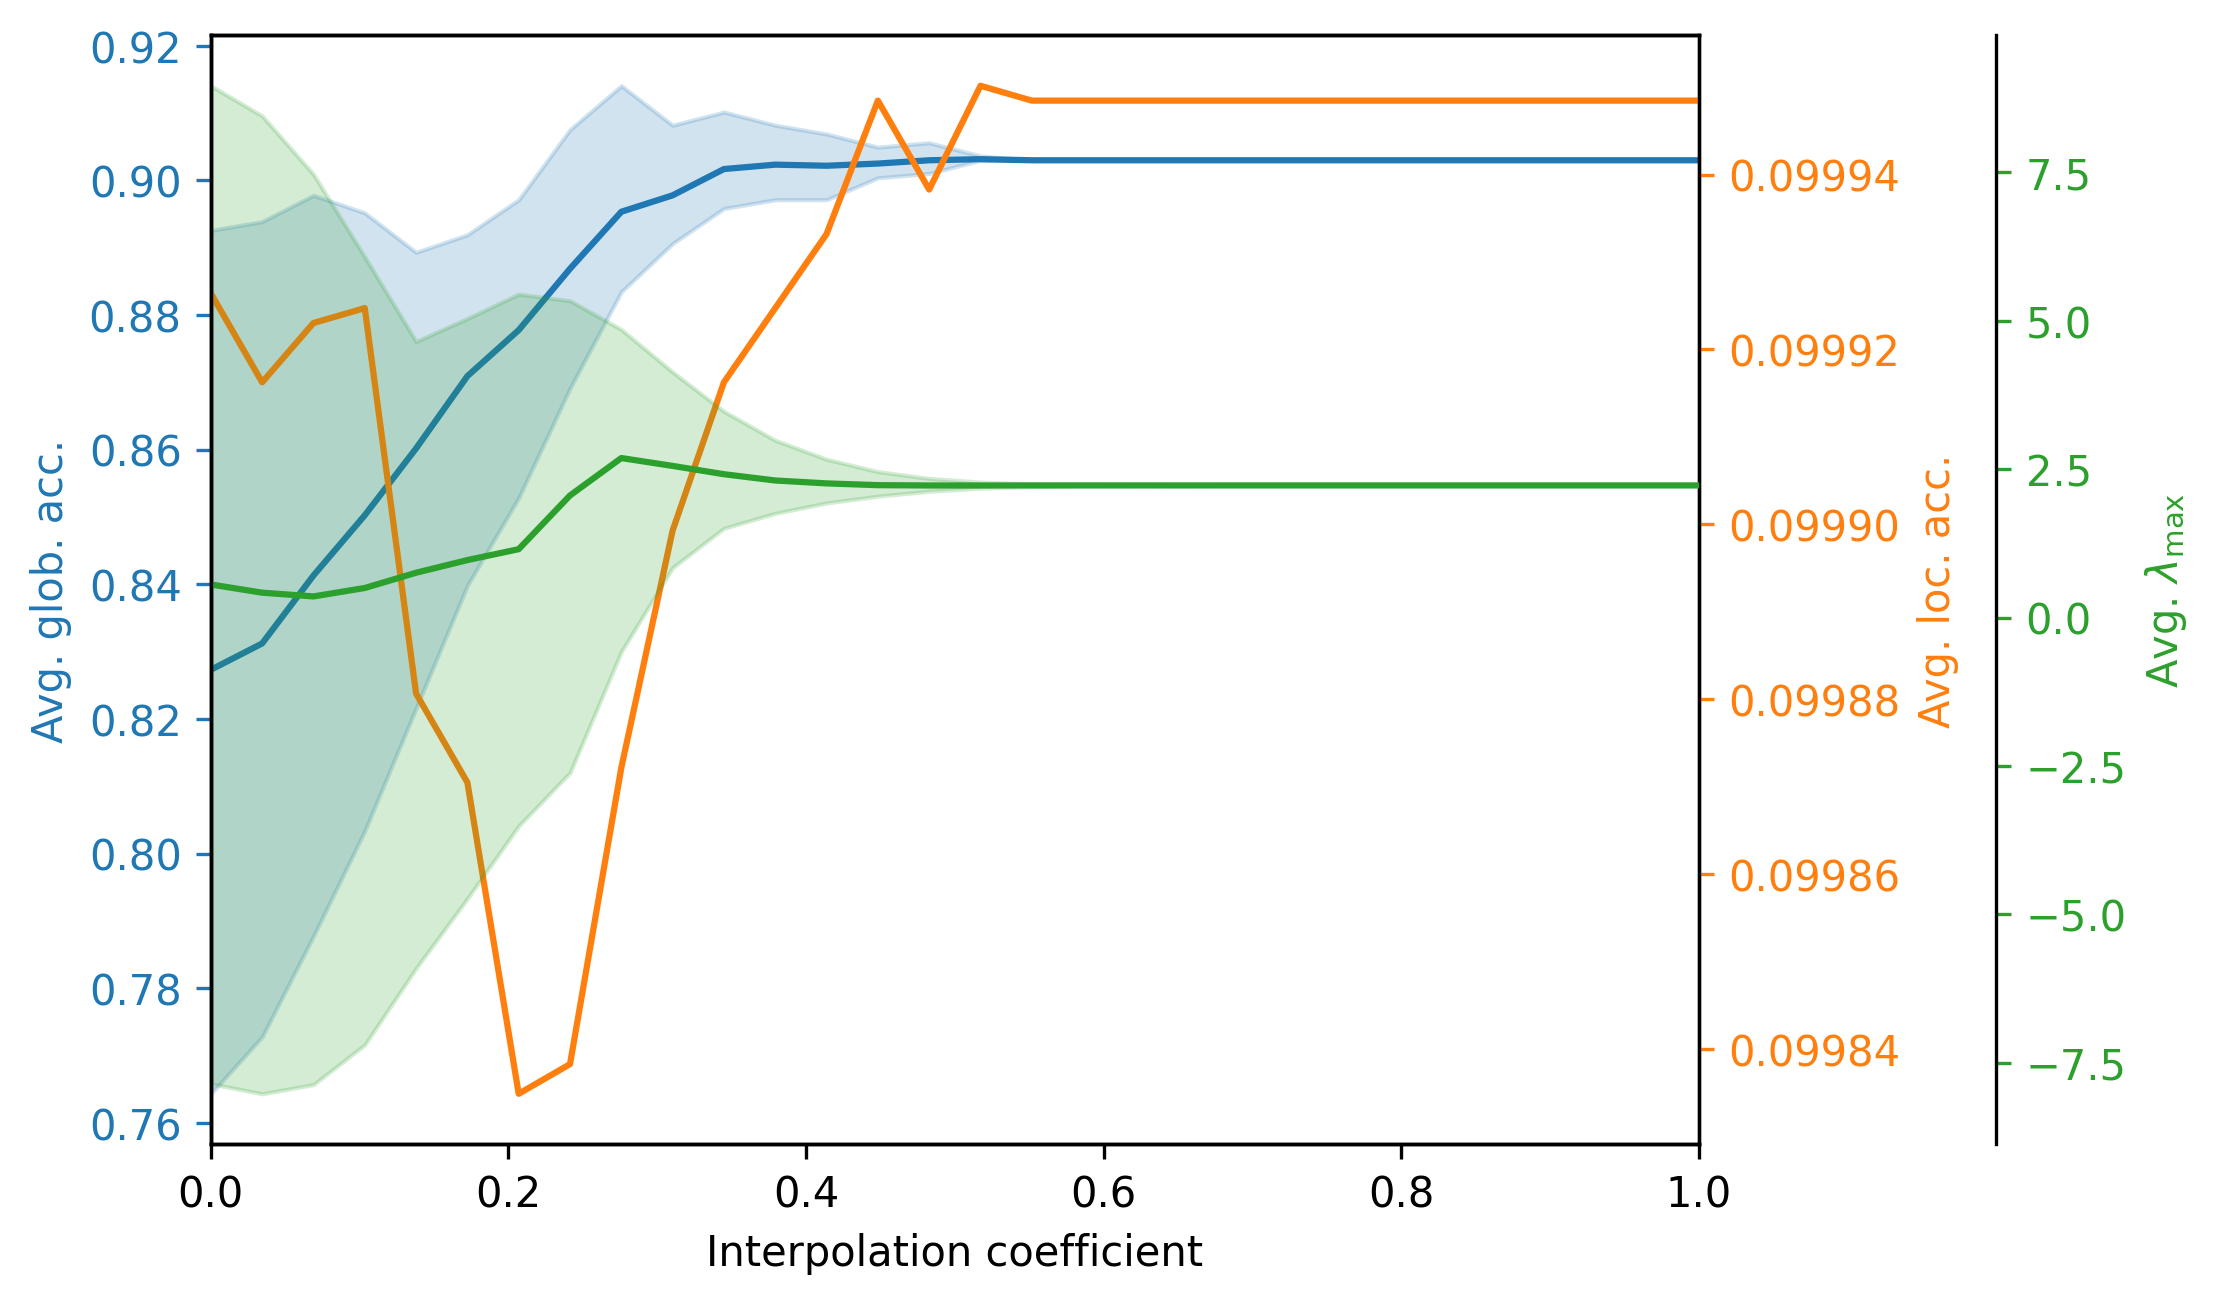

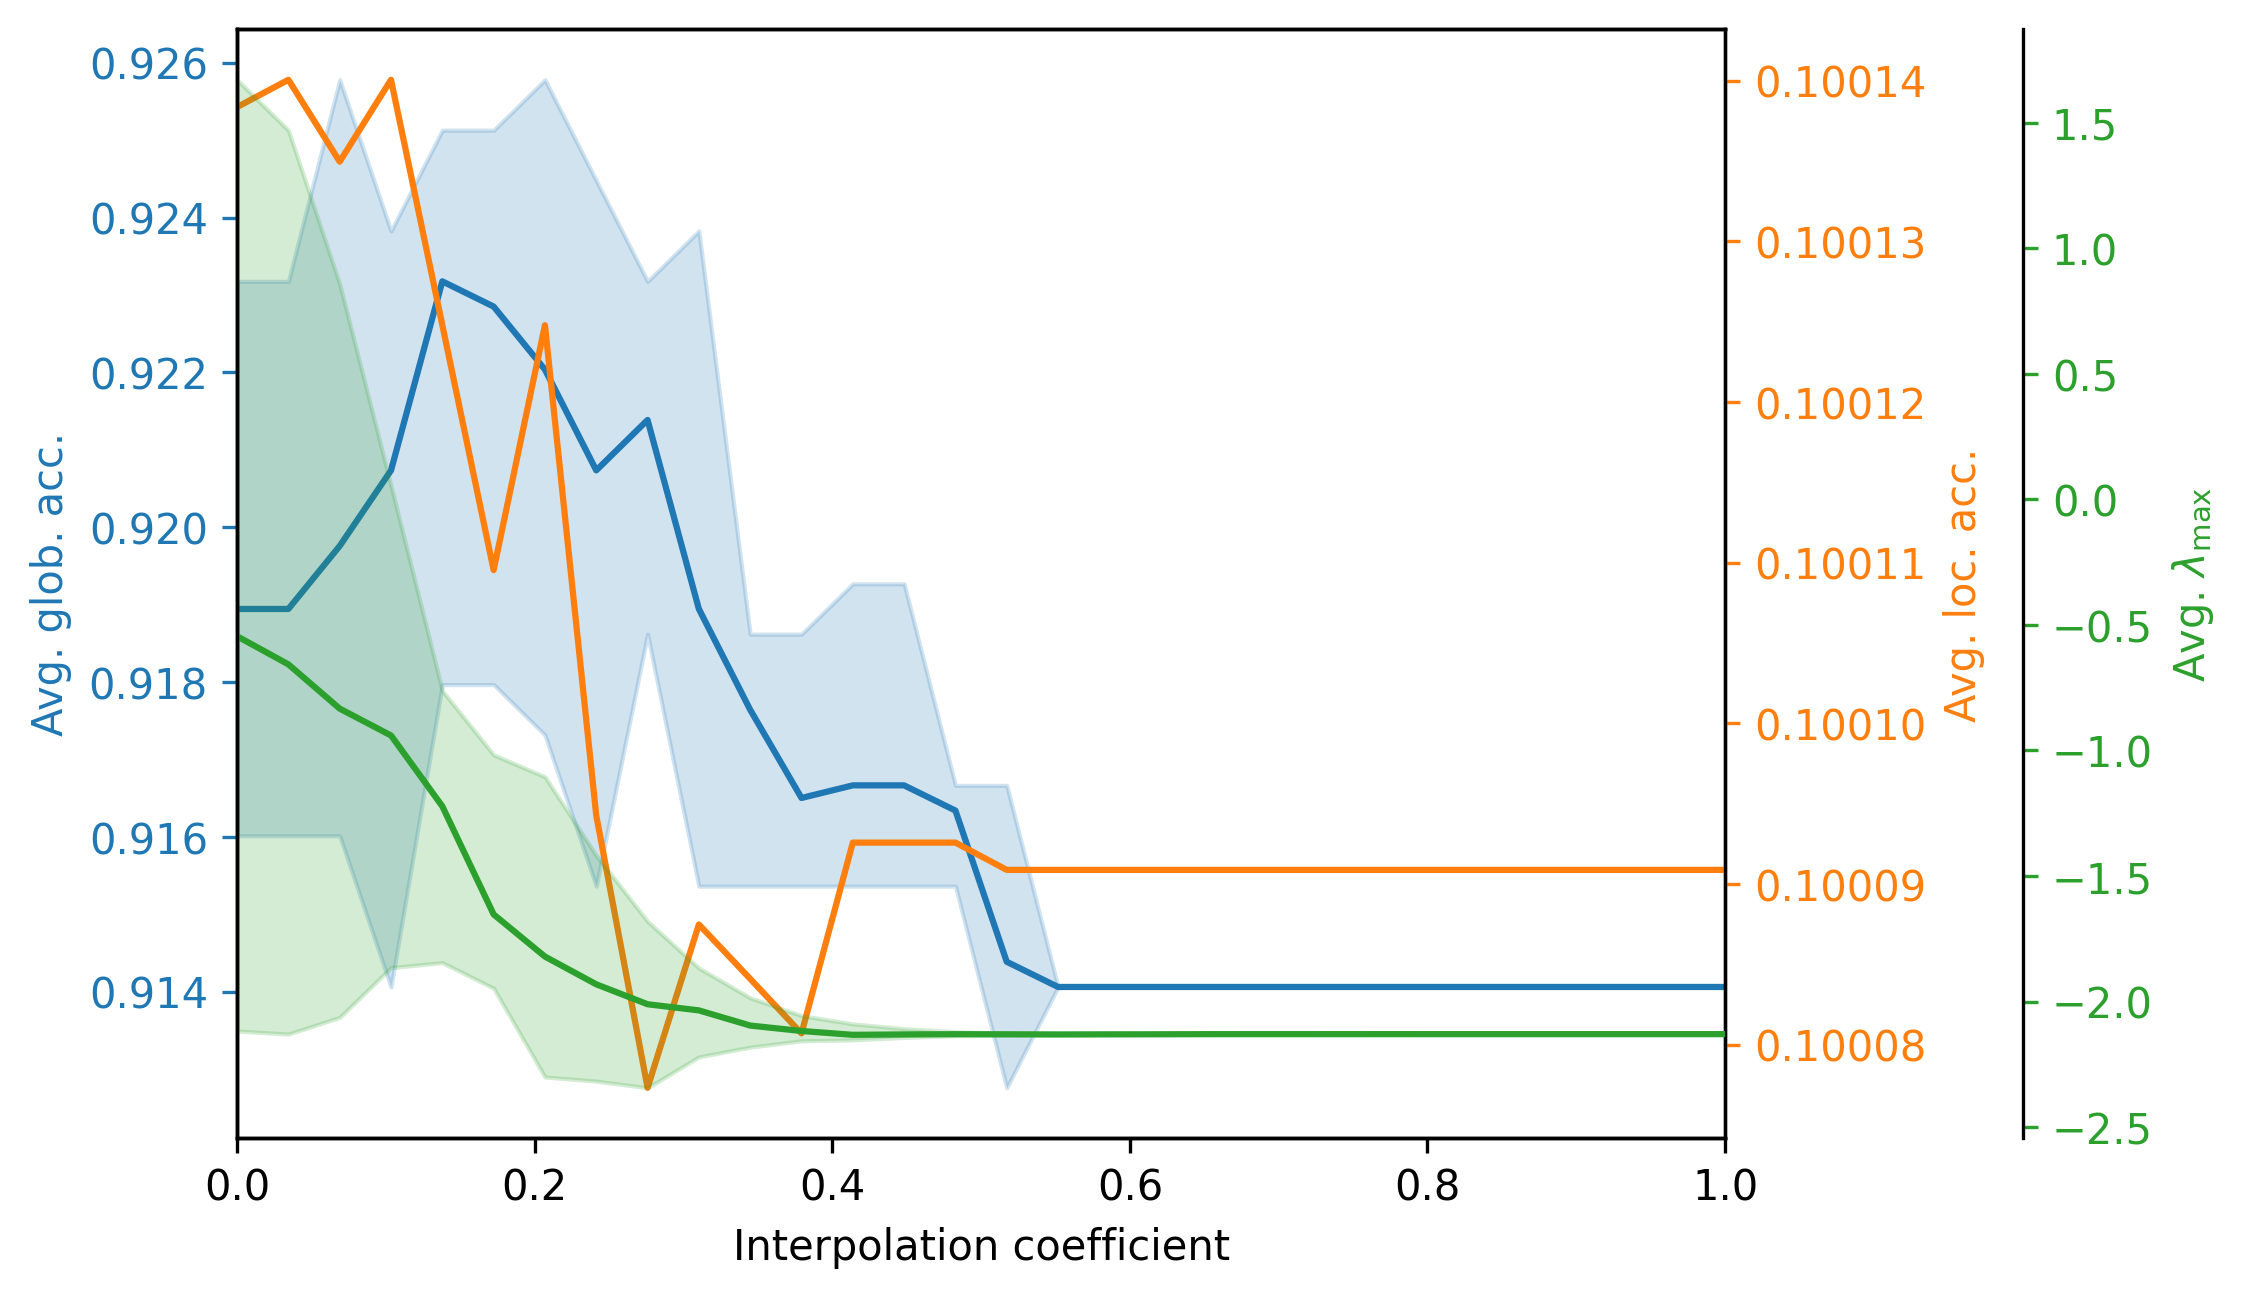

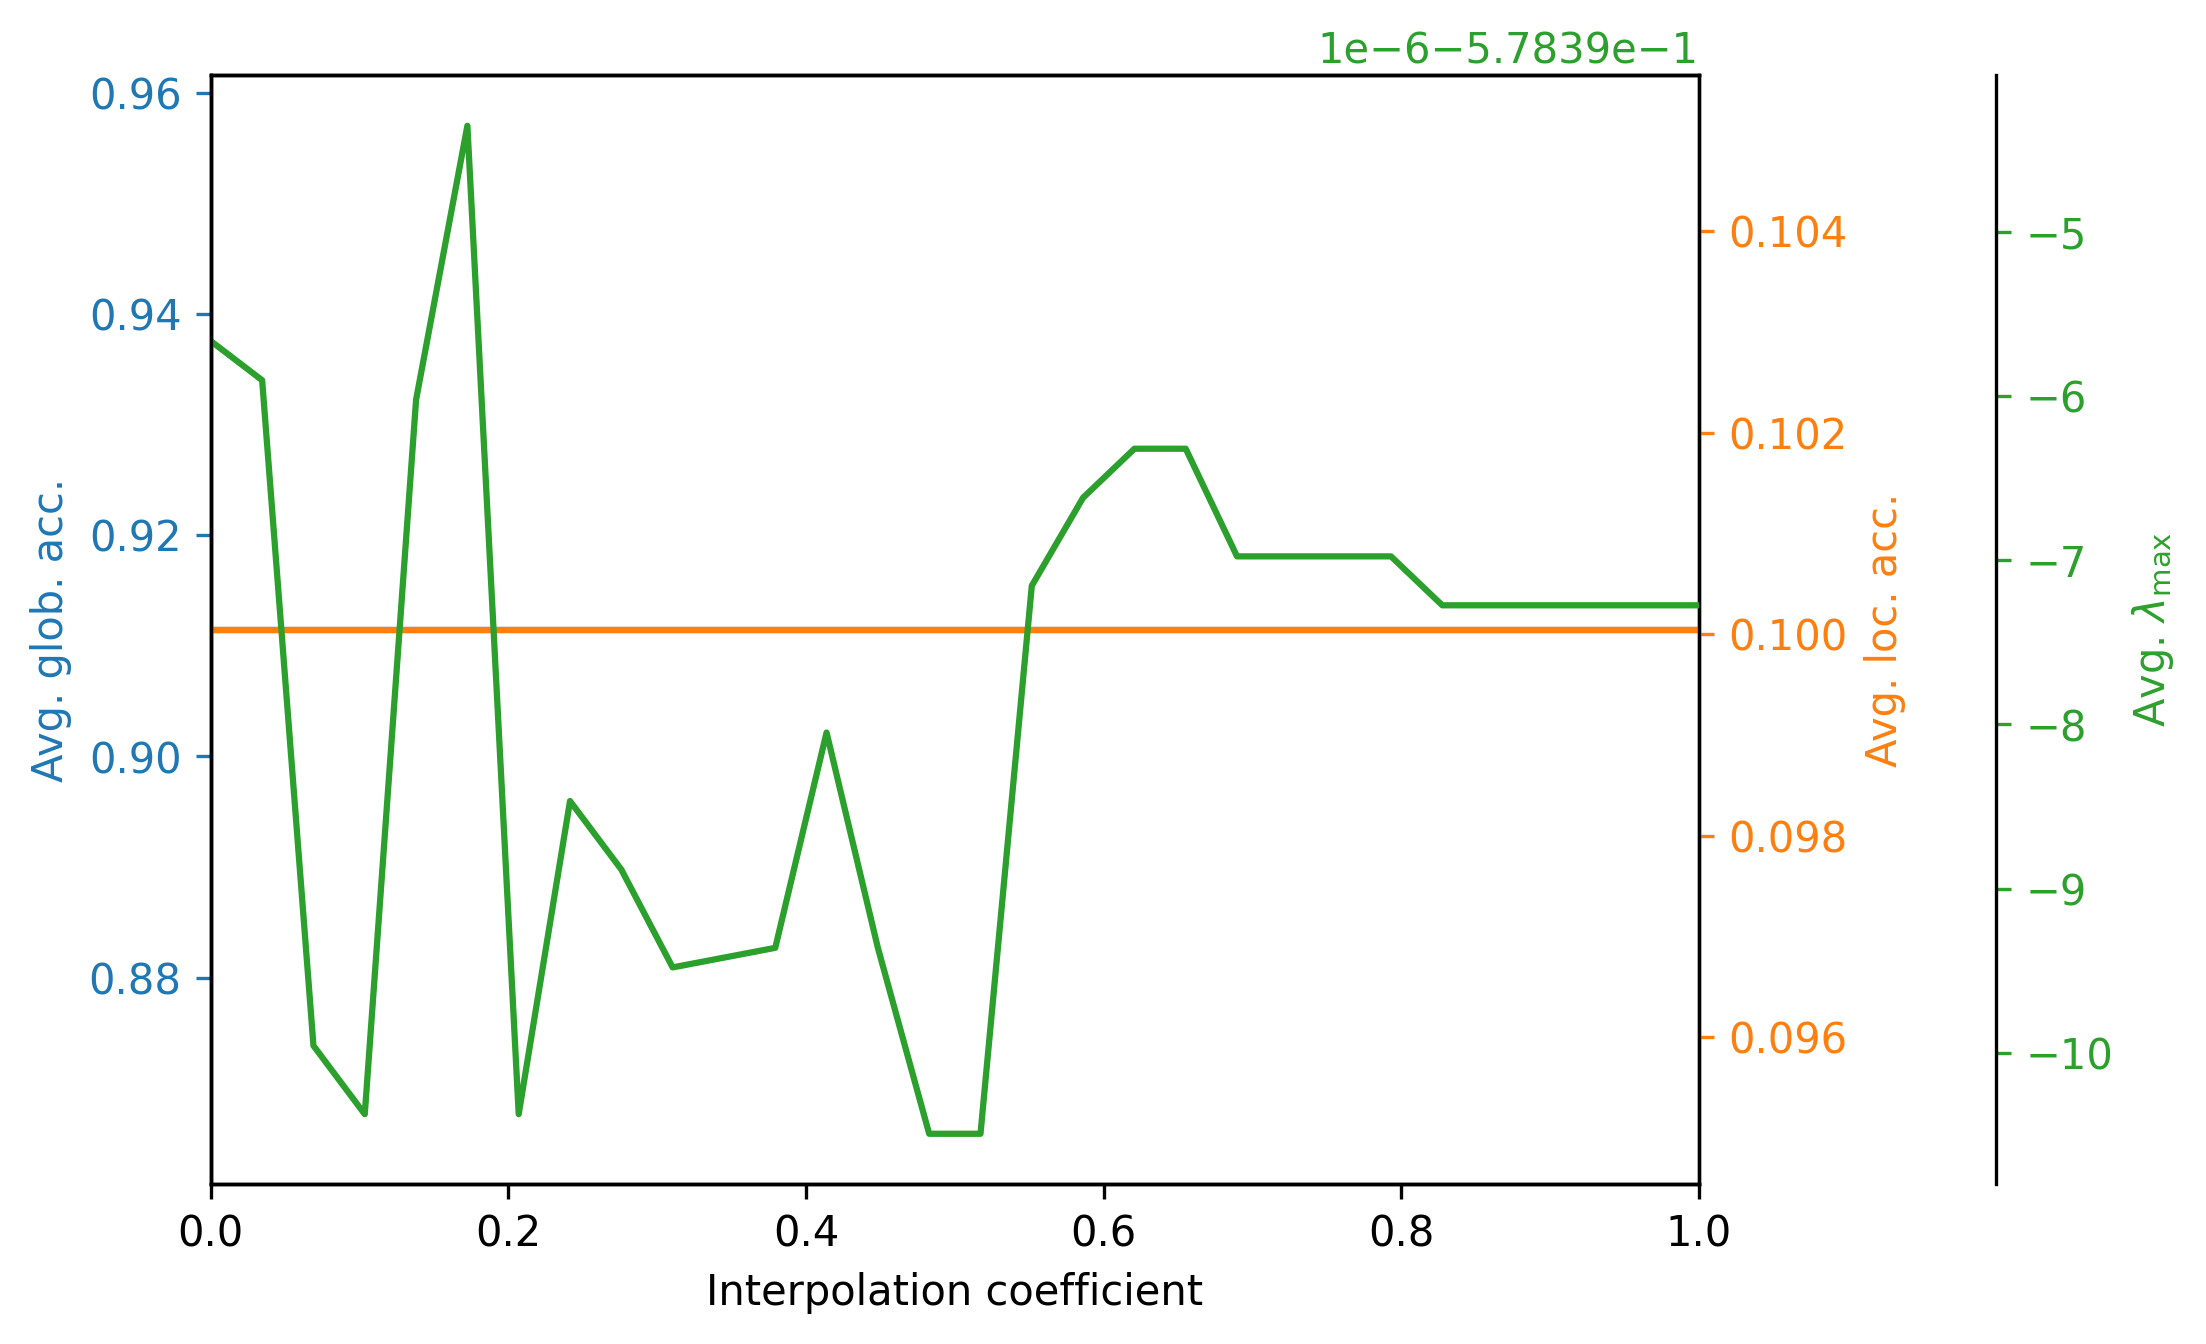

In [ ]:
plt.style.use("seaborn-v0_8-pastel")
for overlap in overlaps: 
    fig, axs = plt.subplots(dpi=300)
    twin1 = axs.twinx()
    twin2 = axs.twinx()
    twin2.spines.right.set_position(("axes", 1.2))
    for c, (metric, ax) in enumerate(zip(metrics[overlap], [axs, twin1, twin2])):
        data = metrics[overlap][metric]
        ax.plot(jnp.linspace(0,1,len(data)), jnp.array(data).mean(axis=-1), c=f"C{c}", label=metric)
        if metric != "Avg. loc. acc.":
            ax.fill_between(jnp.linspace(0,1,len(data)), jnp.array(data).min(axis=-1), jnp.array(data).max(axis=-1), color=f"C{c}", alpha=.2)
        ax.set_ylabel(metric, color=f"C{c}")
        ax.tick_params(axis="y", colors=f"C{c}")
    axs.set_xlabel("Interpolation coefficient")
    axs.set_xlim(0,1)
    # fig.legend()
    fig.savefig(f"img/interpolation_overlap{overlap}.png")

In [12]:
from jax import numpy as jnp
import optax
import jax
jnp.degrees(jnp.arccos(optax.losses.cosine_similarity(jax.random.normal(jax.random.key(2), (10000,)), jax.random.normal(jax.random.key(1), (10000,)))))

Array(89.748375, dtype=float32)